# Financial Advice Document Analysis

I believe that knowledge of personal finance is one of the most needed skills to navigate today's world.  I have gotten my financial education over the years through several methods, but one of the most prominent ways was by reading several books and financial guidance documents; however, much of the financial advice ends up being the same from source to source.

I thought it would be interesting to perform a text analysis on several financial guidance documents I found online to answer some questions like:
1. What are the most talked about topics?
2. Are there any special distinctions between certain financial guidance documents?
3. Can I cluster the documents into different groups so that I can get a complete education by reading only one document from each group?

These questions are addressed using the analysis below.

***NOTE***: These works are available for free online and full credit for the contents of each goes to the original authors mentioned in the document.

## Importing and Cleaning Data

As with any data science project, the first part is collecting the data and getting it into the right format (a pandas dataframe in this instance).  This is an outline of the basic steps below:
1. Create functions to scrape PDF documents.
2. Turn PDF documents into a pandas dataframe.
3. Clean the imported text by removing certain characters and words

In [1]:
# import relevant libraries

# for PDF parsing
import PyPDF2

# for data manipulation
import pandas as pd 
from string import punctuation
import os

# for word processing
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk import ngrams

# for visualizations
import seaborn as sns 
import matplotlib.pylab as plt
from wordcloud import WordCloud

# for tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# for Clustering
from sklearn.cluster import KMeans

# for Excel printout
from openpyxl import Workbook

In [2]:
# Step 1.1: Create function to pass file location and convert PDF to pandas data frame
def PDF_to_pandas(fileLocation):
    # This function is to get the tect from a single pdf file and put it in a pandas data frame with a page column
    # and text column

    # Create file object, opened in raw binary
    pdf_file_obj = open(fileLocation,'rb')

    # Create reader variable that will read the object just created
    pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)

    # Get the number of pages for loop in next step
    num_of_pages = pdf_reader.numPages

    # Create blank variables for loop
    page_list = []
    text_list = []
    df = pd.DataFrame()

    # Extract text and page number
    for i in range(0,num_of_pages):
        text = pdf_reader.getPage(i).extractText()
        text_list.append(text)
        page = i+1
        page_list.append(page)

    df['page'] = page_list
    df['text'] = text_list

    pdf_file_obj.close()

    return df

In [3]:
# Step 1.2: Create a function to loop several documents, and prodcue a data frame given a folder path
def PDF_folder_to_pandas(folderPath):
    # Given a folder path where the folder only has PDF documents in it, this takes each PDF, converts it into text, 
    # and outputs a single data frame with page, text, and document columns

    df = pd.DataFrame()

    for file in os.listdir(folderPath):
        path = folderPath + file
        df_loop = PDF_to_pandas(path)
        df_loop['document'] = file
        df = pd.concat([df,df_loop])

    return df

In [4]:
#Step 2: Get dataframe of the PDFs you want to analyze by providing folder path
folder_path = "C:/Users/Michael/OneDrive/Python/Financial Advice Documents/" # Insert your folder path here
df = PDF_folder_to_pandas(folder_path)

In [5]:
# Step 3: Clean the text columns

# Start by downloading stopwords, punctuations, and creating a custom dictionary of words to remove if needed
stopwords = nltk.corpus.stopwords.words('english')
punctuation = punctuation.replace("'","") # Remove ' because it is important to stop words and analysis
punctuation = punctuation + '™˜˚˛˝˙ˆˇ˘ł' # Adding additional characters to remove
numbers = '1234567890'
custom_stop_words = ['august',
                     'may',
                     'raymond',
                     'james'] # This list is created after some basic analysis

# Clean the text column
df['text'] = df['text'].replace('\n',' ', regex=True) # Remove line breaks
df['text'] = df['text'].apply(lambda x: ''.join([l for l  in x if l not in punctuation])) # Remove punctuations
df['text'] = df['text'].apply(lambda x: ''.join([l for l  in x if l not in numbers])) # Remove numbers
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stopwords)])) # Remove INDIVIDUAL words in stopwords list
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (custom_stop_words)])) # Remove INDIVIDUAL words in custom stopwords list

# Transform text into a blob by document
df['text'] = df.groupby(['document'])['text'].transform(lambda x: ' '.join(x)) # Combine all pages
df = df.drop(['page'], axis=1)
df = df.drop_duplicates().reset_index().drop(['index'], axis=1)

## Word Count Analysis

Now that the data has been cleaned, we can begin to start performing an analysis on it.  The first analysis is a simple count of the number of times each word appears in the corpus.  This helps address the first question of what are the common topics.  To give some more detail to this analysis, I performed it over an ngram range to see what word combinations are important as well.

In [6]:
# Step 4: Create a function that creates the X most common words
def ngram_count(df_text_column, ngram_split = 1, num_of_words = 100):
    # Given a single column containing text from a pandas data frame, count the X most common ngrams with length Y for the
    # entire corpus. Outputs a pandas data frame with columns for ngrams (words) and their count in the corpus.

    # blank string for combining all text
    text_blob = ''

    # combinen all text
    for i in range(0, len(df_text_column)):
        text_blob = text_blob + df_text_column.iloc[i]

    # count individual words
    ngram_counts = Counter(ngrams(text_blob.split(), ngram_split))
    df_most_common_words = pd.DataFrame(ngram_counts.most_common(num_of_words))
    df_most_common_words = df_most_common_words.rename(columns={0:"words", 1:"count"})
    df_most_common_words['words'] = df_most_common_words['words'].astype(str)
    df_most_common_words['words'] = df_most_common_words['words'].replace('[,()\']','', regex=True)

    return df_most_common_words

Below are the results of the word count analysis.  The most interesting and usefull insights I believe occur in the 2 word ngram bar chart.  This gives some good high level topics a person should be familiar with like credit cards, credit reports, savings accounts, and interest rates, but the one that took me by surprise was small business.  This is partially due to the fact that one of the documents I selected focused on small business money management, but I'm surprised it was mentioned frequently enough over the entire corpus to make the list.

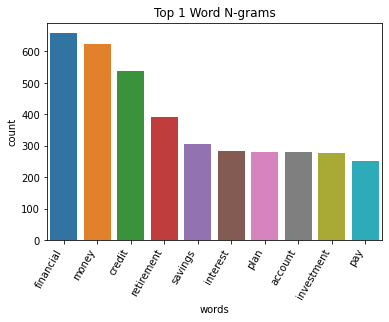

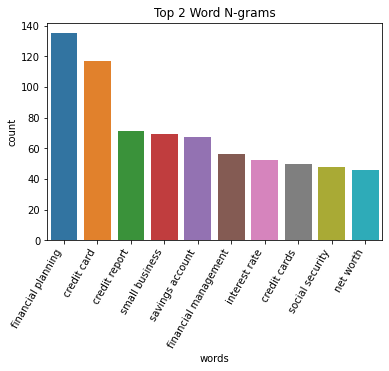

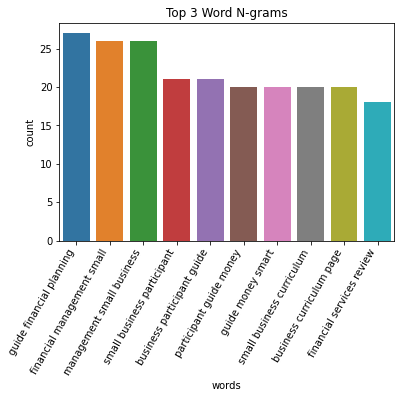

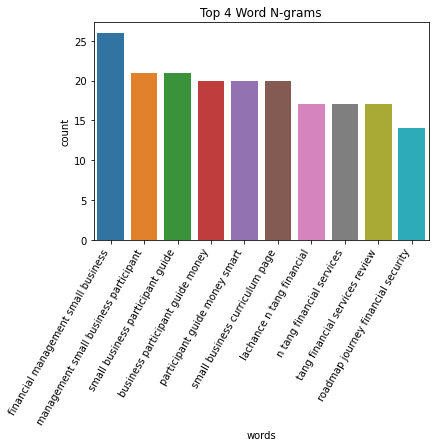

In [7]:
# Step 5: Loop the ngram_count function created to see the most used ngrams and display results as a bar chart
for i in range(1,5):
    df_most_common_ngram = ngram_count(df['text'], ngram_split = i)

    # create visualization
    sns.barplot(data = df_most_common_ngram[:10],
                x = 'words',
                y = 'count')

    plt.xticks(rotation=60, ha='right')
    plt.title('Top ' + str(i) + ' Word N-grams')
    plt.show()

Since more detailed analysis may be wanted, I included an optional chunk below going over how to save the results to an Excel file.  The outputs are available in the Outputs folder of the project.

In [8]:
# Step 6 (Optional): Create a function that counts multiple ngram splits and saves to an Excel File for further analysis
def df_corpus_to_excel_word_count(df_text_column,file_name, ngram_start = 1, ngram_end = 1):
    writer = pd.ExcelWriter((file_name + '.xlsx'))

    for i in range(ngram_start,ngram_end+1):
        ngram_count_df = ngram_count(df_text_column, ngram_split=i)
        ngram_count_df.to_excel(writer, sheet_name = str(i))

    writer.save()

# Example of Step 6
df_corpus_to_excel_word_count(df['text'],'ngram_combinations',ngram_end=5)

## TF-IDF Analysis

TF-IDF (Term Frequency-Inverse Document Frequency) is a term that is a little complicated to discuss using text, but the main idea of it is that it is a numerical way to represent if a word (or ngram group) is **BOTH** important (as interpreted by being mentioned several times) and unique to specific documents (as interpreted by being mentioned in a low number of documents).  This type of analysis can give quick insight to what some unique topics are to help prime a readers mind about what to take away before reading a document.

In [9]:
# Step 7: Complete the tf-idf analysis on the document words
tfidf_vectorizer = TfidfVectorizer(ngram_range = (2,4))
# Produces x rows (the number of documents) by y columns (the ratings of unique word groupings)
X = tfidf_vectorizer.fit_transform(df['text'])

In [10]:
# Step 8: Get results ready for further analysis

# Clean up the document names
doc_names = os.listdir(folder_path)
doc_names = [item.replace(".pdf","") for item in doc_names]

# Place tf-idf values in a pandas data frame
df_tfidf = pd.DataFrame(X.T.toarray(), index=tfidf_vectorizer.get_feature_names(), columns = doc_names)

For this, I'll be saving the results directly to an Excel file for viewing.  These insights are typically document specific and require an SME to interpret the useablility of the words.  As an example, I'll look at the *financialliteracyguide.pdf* document.  Looking at some of the top words, some of the specific and unique topics it seems to mention are tax liability and identity theft. Both of these are important when maintaining good financial health and if either were of interest to me, this analysis would suggest this be the document I need to read.

In [11]:
#Step 9: Create blank Excel Work book to append to
Workbook().save(filename='TFIDF.xlsx')

In [12]:
# Step 10: Analyze further by finding how many of the documents the word combinations appear in and what those documents 
# are.  Loop this for all documents in the collection to produce an Excel output with each tab being a document
for document_analyzed in doc_names:

    df_tfidf_loop = df_tfidf.sort_values(by=[document_analyzed],ascending=False).nlargest(150,document_analyzed)

    document_count = []
    document_appearance_list = []

    for words in df_tfidf_loop.index:
        # Look at original data frames for these loops with text blobs
        documents_list = df[df['text'].str.contains(words, case = False)].document.tolist()
        count = df[df['text'].str.contains(words, case = False)].count()[0]
        document_count.append(count)
        document_appearance_list.append(documents_list)

    df_tfidf_loop['document_count'] = document_count
    df_tfidf_loop['documents_in'] = document_appearance_list

    # Clean the "documents_in" column
    df_tfidf_loop['documents_in'] = df_tfidf_loop['documents_in'].astype(str)
    df_tfidf_loop['documents_in'] = df_tfidf_loop['documents_in'].replace('[\[\]()\']','', regex=True)
    df_tfidf_loop['documents_in'] = df_tfidf_loop['documents_in'].replace('.pdf', '', regex = True)

    # Select only the columns wanted for each document
    df_tfidf_loop = df_tfidf_loop[[document_analyzed,'document_count','documents_in']]
    
    # Due to the different stop words in the tf-idf module and the nltk module, some words appear zero times so remove those
    df_tfidf_loop = df_tfidf_loop[df_tfidf_loop['document_count']!=0]
    df_tfidf_loop = df_tfidf_loop.sort_values(by=[document_analyzed], ascending=False).nlargest(100,document_analyzed)
    df_tfidf_loop = df_tfidf_loop.rename(columns={document_analyzed: 'tfidf'})

    # Print to Excel File
    with pd.ExcelWriter('TFIDF.xlsx', engine='openpyxl', mode='a') as writer:
        df_tfidf_loop.to_excel(writer, sheet_name=document_analyzed)

    print(document_analyzed, 'Completed')

print('Finished!')


Financial advice and trust Completed
financialliteracyguide Completed


fundamentals-of-financial-planning Completed
money_management Completed
PARTICIPANT_GUIDE_FINANCIAL_MANAGEMENT Completed
poweraguidetofinacialplanning Completed
savings-fitness Completed
sec-guide-to-savings-and-investing Completed
wealth Completed
Your-Spending-Your-Savings-Your-Future Completed
Finished!


## K Means Clustering

With a topic like Personal Finance, my experience is that several of the same pieces of advice get reiterated over and over again.  With that in mind, I would like to see if I could apply machine learning to cluster the documents that are most similar together.  This idea is if I identify which documents are the most similar so I can read only one document from each cluster and get a full understanding of all the topics covered from the corpus.

In [13]:
# Step 11: Get a new vectorizer since this is different than before and will be word for word comparison, not ngram
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])

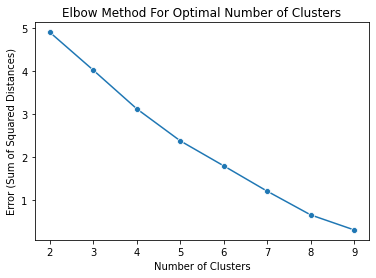

In [14]:
# Step 12: Use K Means clustering varying the number of clusters to find the optimum number using a visual elbow method

# Blank lists for loop
sum_of_squared_distances = []
test_cluster_num = []

# Testing different numbers of clusters
for number_of_clusters in range(2,10):
   km = KMeans(n_clusters=number_of_clusters, max_iter=100, n_init=10, random_state=123)
   km = km.fit(X)
   sum_of_squared_distances.append(km.inertia_)
   test_cluster_num.append(number_of_clusters)

# Visualization
sns.lineplot(x = test_cluster_num,
             y = sum_of_squared_distances,
             marker = "o")
plt.xlabel('Number of Clusters')
plt.ylabel('Error (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [15]:
# Step 13: Run the clustering with the optimimal number of clusters and add the cluster number to the original dataframe
optimimum_number_of_clusters = 5
opt_model = KMeans(n_clusters=optimimum_number_of_clusters, max_iter=200, n_init=10, random_state=123)
opt_model.fit(X)
df['cluster'] = opt_model.labels_

Cluster: 0
Titles
fundamentals-of-financial-planning.pdf
                   savings-fitness.pdf
sec-guide-to-savings-and-investing.pdf


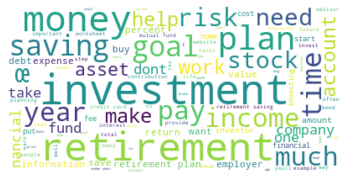

Cluster: 1
Titles
                financialliteracyguide.pdf
                      money_management.pdf
                                wealth.pdf
Your-Spending-Your-Savings-Your-Future.pdf


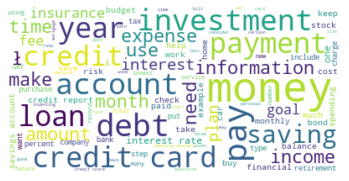

Cluster: 2
Titles
PARTICIPANT_GUIDE_FINANCIAL_MANAGEMENT.pdf


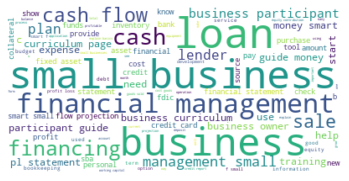

Cluster: 3
Titles
poweraguidetofinacialplanning.pdf


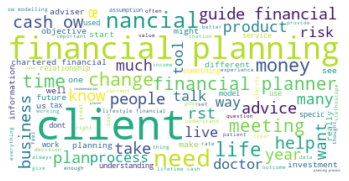

Cluster: 4
Titles
Financial advice and trust.pdf


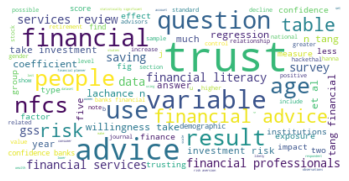

In [16]:
# Step 14: Present the results of each cluster using a word cloud to glean insight of common topics for cluster

# Loop to create a word cloud for each cluster
for cluster in range(0,optimimum_number_of_clusters):
   # Create heading for each section
   print('Cluster: {}'.format(cluster))
   print('Titles')
   titles=df[df.cluster==cluster]['document']         
   print(titles.to_string(index=False))

   # Subset the dataframe and create the Wordcloud data
   df_loop=df[df.cluster==cluster]
   text=df_loop['text'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   
   # Display the Wordcloud figure
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

## Thoughts on Clustering Results

Looking at the clustering, it seems to have created two large groups in clusters 0 and 1.  Cluster 0 seems to be focused on investments only while Cluster 1 is focused on a wide range of topics from investments to debt, credit, loans, and expenses.  The other clusters only contain one document each and they may be looked at as being more unique which could make sense looking through them as Cluster 2's document has a lot on trusts, Cluster 3's document is focused around business, and cluster 4's document is meant more for a Financial Planner than a normal everyday person (which is why the word client comes up so often).  I think that the clustering approach actually turned out fairly well and I would feel more confident in reading one document from each cluster so that I can cut my reading down from the corpus from 10 to 5 documents.

## Final Thoughts

I enjoyed looking through the documents and reaffirming much of the knowledge I already had in person finance.  I think this approach could be used though to quickly glean insights from much larger corpuses and help condense information down into core topics to help people learn faster. I would be excited to try and apply this appoach to a new dataset and see what insights I could glean and how quickly I could pick them up.